In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import matplotlib.colors as mpc
import networkx
import progressbar
import astropy.cosmology as apc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
# Slist = h5py.File('SatelliteList_V2_withAngles_n500.h5', 'r')
# Satellites = Slist['SatelliteList'][()]
# Centrals = Slist['SatelliteCentral'][()]
# CosCen = Slist['CosCen'][()]
# CosVel = Slist['CosVel'][()]
# #LzL = Slist['LZ_L'][()]
# Satellites.size

In [5]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [6]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [7]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [8]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+centralID)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []
    zlist = []
    SFRlist = []
    distlist = []
    STMasslist = []
    z2, z1 = -1., -1.
    
    for mm, mmC in zip(mtree[1:], mtreeC[1:]): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        snapC, iddC = split_unique_id(int(mmC))
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
#             # and the temperature
#             IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
#             Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
#             Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
#             ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
#             val2 = tempFromMass(Mass, Abund, IE, ne1)
#             templist2.extend(list(val2))
            # and the metallicity
#             AbundatTime = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
#             val = np.log10((AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)) - NfeNhe_sun
#             val = (AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)
#             templist.extend(list(val))
            zz = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            zlist.extend([zz]*tempIds.size)
            
            # and the distance to the centre (of the galaxy in virial radius units)
            galP = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
            cenP = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
            gro = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
            R200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][gro]
            
            defe = cenP - galP
            dist = np.sqrt(np.sum(defe**2.))/R200
            
            if dist<2.:
                z2 = zz
            if dist<1.:
                z1 = zz
            
            SFRs = sim['SnapNumber_{}/PartType0/StarFormationRate'.format(snap)][tempOff[0]:tempOff[1]]
            
            StarOffs = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
            StarMass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][StarOffs[0]:StarOffs[1]]
            
            SFR = np.sum(SFRs)/(np.sum(StarMass)*1e10)
            #SFR = np.sum(SFRs)
            SFRlist.extend([SFR]*tempIds.size)
            distlist.extend([dist]*tempIds.size)
            STMasslist.extend([np.sum(StarMass)]*tempIds.size)
            
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    zlist = np.array(zlist)
    SFRlist = np.array(SFRlist)
    distlist = np.array(distlist)
    STMasslist = np.array(STMasslist)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    zlist = zlist[Idunique]
    SFRlist = SFRlist[Idunique]
    distlist = distlist[Idunique]
    STMasslist = STMasslist[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    zlist_, Idlist_ = zlist[iidex_], Idlist[iidex_]
    SFRlist_ = SFRlist[iidex_]
    distlist_ = distlist[iidex_]
    STMasslist_ = STMasslist[iidex]
    
    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    zorder = np.zeros(IndexT_.size)
    
    zorder[is1] = zlist_[is2]
    
    SFRorder = np.zeros(IndexT_.size)
    SFRorder[is1] = SFRlist_[is2]

    distorder = np.zeros(IndexT_.size)
    distorder[is1] = distlist_[is2]
    
    STMassorder = np.zeros(IndexT_.size)
    STMassorder[is1] = STMasslist_[is2]
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_]
    GassAbundances = sim['SnapNumber_128/PartType0/Abundances'][IndexT_]
    
    GasMasses = GasMasses/STMassorder
    return GasMasses, GassAbundances, zorder, SFRorder, distorder, z1, z2

In [9]:
# select the couple of galaxies to analyse
Slist = h5py.File('SatelliteList_V2_withAngles_n500_KoK04.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]


ingroup = np.where(Centrals==4337)
SatCell = Satellites[ingroup]

STMass = []
for s in SatCell:
    Offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][s].astype('int')
    Stm = sim['SnapNumber_128/PartType4/Masses'][Offst[0]:Offst[1]]
    STMass.append(np.sum(Stm))
    
maxM, minM = np.max(STMass), np.min(STMass)
i1 = np.where(STMass==maxM)[0][0]
i2 = np.where(STMass==minM)[0][0]

S1 = SatCell[i1]
S2 = SatCell[i2]

S1, S2, np.log10(maxM*1e10), np.log10(minM*1e10)

(4338, 4343, 8.824296879623581, 8.100917132543179)

In [10]:
# ok, lets test this
GasMasses_1, GassAbundances_1, zorder_1, SFRorder_1, distlist_1, z1_1, z2_1 = getAllLastP(S1, 4337)

zu_1 = np.unique(zorder_1)
tzu_1 = Cosmo.lookback_time(zu_1).value

Mass_1 = []
SFRor_1 = []
dist_1 = []

for z in zu_1:
    ii = np.where(zorder_1==z)[0]
    GMass = np.sum(GasMasses_1[ii])
    SFRt = SFRorder_1[ii[0]]
    distt = np.mean(distlist_1[ii])
    Mass_1.append(GMass)
    SFRor_1.append(SFRt)
    dist_1.append(distt)
    
Mass_1 = np.array(Mass_1)
SFRor_1 = np.array(SFRor_1)
dist_1 = np.array(dist_1)

In [11]:
# ok, lets test this
GasMasses_2, GassAbundances_2, zorder_2, SFRorder_2, distlist_2, z1_2, z2_2 = getAllLastP(S2, 4337)

zu_2 = np.unique(zorder_2)
tzu_2 = Cosmo.lookback_time(zu_2).value

Mass_2 = []
SFRor_2 = []
dist_2 = []

for z in zu_2:
    ii = np.where(zorder_2==z)[0]
    GMass = np.sum(GasMasses_2[ii])
    SFRt = SFRorder_2[ii[0]]
    distt = np.mean(distlist_2[ii])
    Mass_2.append(GMass)
    SFRor_2.append(SFRt)
    dist_2.append(distt)
    
Mass_2 = np.array(Mass_2)
SFRor_2 = np.array(SFRor_2)
dist_2 = np.array(dist_2)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in true_divide


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


(0.0, 3.0)

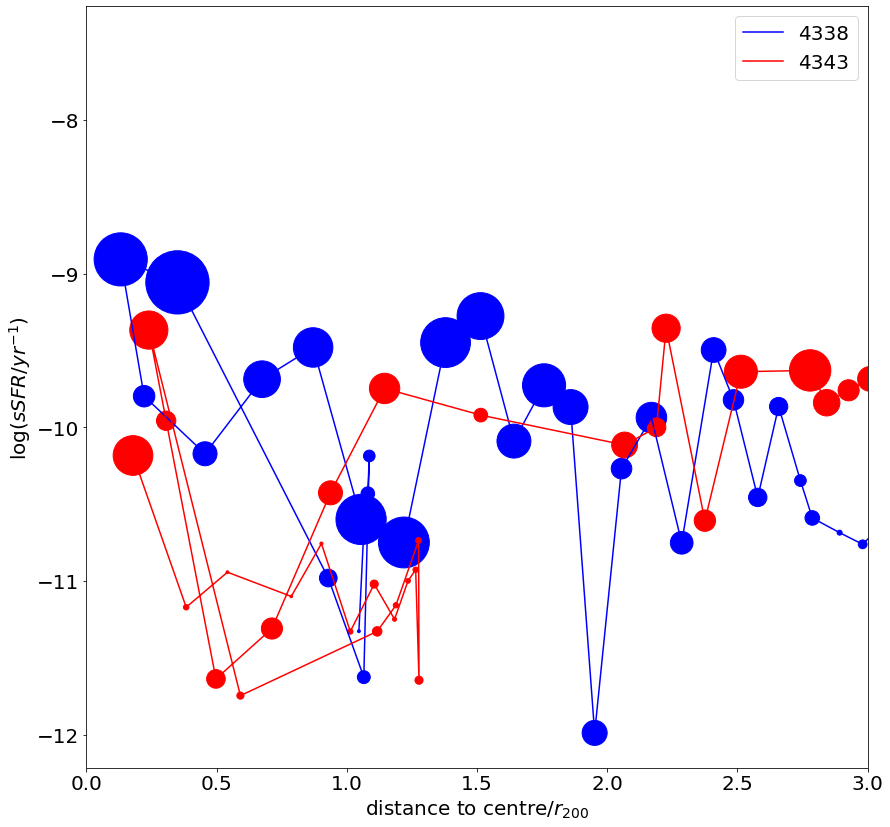

In [12]:
pl.figure(figsize=(14,14))

i1 = np.where(np.isinf(np.log10(SFRor_1))==False)
i2 = np.where(np.isinf(np.log10(SFRor_2))==False)

pl.scatter(dist_1[i1], np.log10(SFRor_1[i1]), s=Mass_1[i1]*1e4, color='blue')
pl.scatter(dist_2[i2], np.log10(SFRor_2[i2]), s=Mass_2[i2]*1e4, color='red')

pl.plot(dist_1[i1], np.log10(SFRor_1[i1]), color='blue', label=S1)
pl.plot(dist_2[i2], np.log10(SFRor_2[i2]), color='red', label=S2)

pl.legend(loc='best')

pl.ylabel('$\log(sSFR/yr^{-1})$')
# pl.ylabel('log(sSFR/yr⁻¹)')
pl.xlabel('distance to centre/$r_{200}$')

pl.xlim(0, 3.)

In [13]:
ingroup = np.where(Centrals==4469)
SatCell = Satellites[ingroup]

STMass = []
for s in SatCell:
    Offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][s].astype('int')
    Stm = sim['SnapNumber_128/PartType4/Masses'][Offst[0]:Offst[1]]
    STMass.append(np.sum(Stm))
    
maxM, minM = np.max(STMass), np.min(STMass)
i1 = np.where(STMass==maxM)[0][0]
i2 = np.where(STMass==minM)[0][0]

S1 = SatCell[i1]
S2 = SatCell[i2]

S1, S2, np.log10(maxM*1e10), np.log10(minM*1e10)

(4471, 4478, 9.561488709317695, 8.021852922806016)

In [14]:
GasMasses_1, GassAbundances_1, zorder_1, SFRorder_1, distlist_1, z1_1, z2_1 = getAllLastP(S1, 4469)

zu_1 = np.unique(zorder_1)
tzu_1 = Cosmo.lookback_time(zu_1).value

Mass_1 = []
SFRor_1 = []
dist_1 = []

for z in zu_1:
    ii = np.where(zorder_1==z)[0]
    GMass = np.sum(GasMasses_1[ii])
    SFRt = SFRorder_1[ii[0]]
    distt = np.mean(distlist_1[ii])
    Mass_1.append(GMass)
    SFRor_1.append(SFRt)
    dist_1.append(distt)
    
Mass_1 = np.array(Mass_1)
SFRor_1 = np.array(SFRor_1)
dist_1 = np.array(dist_1)

In [15]:
# ok, lets test this
GasMasses_2, GassAbundances_2, zorder_2, SFRorder_2, distlist_2, z1_2, z2_2 = getAllLastP(S2, 4469)

zu_2 = np.unique(zorder_2)
tzu_2 = Cosmo.lookback_time(zu_2).value

Mass_2 = []
SFRor_2 = []
dist_2 = []

for z in zu_2:
    ii = np.where(zorder_2==z)[0]
    GMass = np.sum(GasMasses_2[ii])
    SFRt = SFRorder_2[ii[0]]
    distt = np.mean(distlist_2[ii])
    Mass_2.append(GMass)
    SFRor_2.append(SFRt)
    dist_2.append(distt)
    
Mass_2 = np.array(Mass_2)
SFRor_2 = np.array(SFRor_2)
dist_2 = np.array(dist_2)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


(0.0, 3.0)

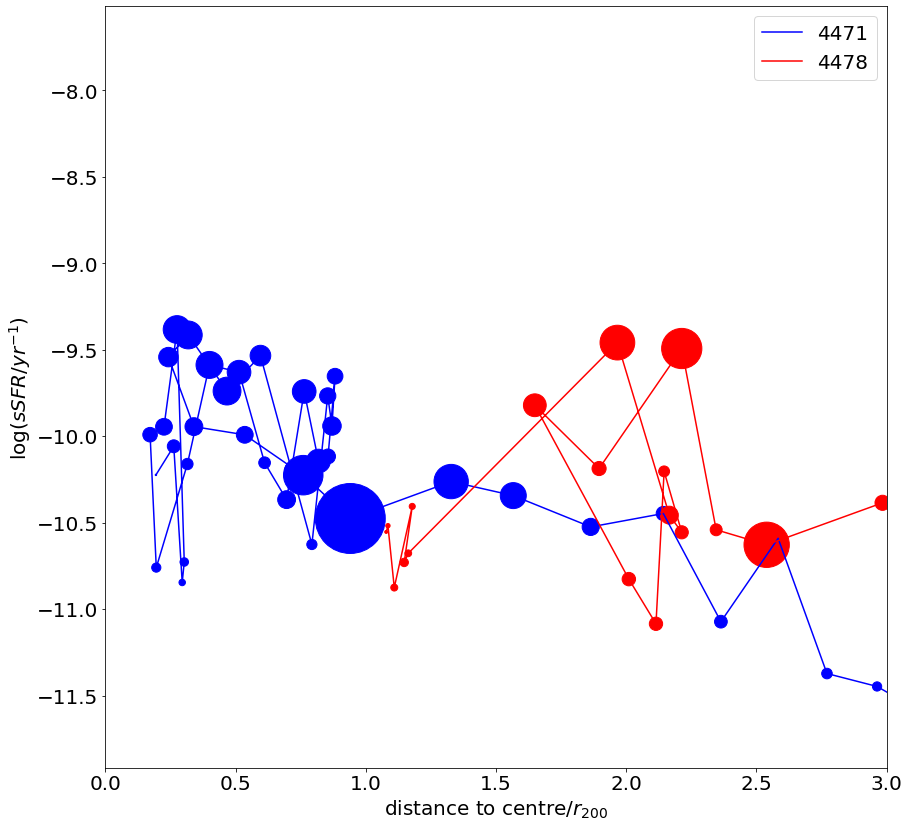

In [16]:
pl.figure(figsize=(14,14))

i1 = np.where(np.isinf(np.log10(SFRor_1))==False)
i2 = np.where(np.isinf(np.log10(SFRor_2))==False)

pl.scatter(dist_1[i1], np.log10(SFRor_1[i1]), s=Mass_1[i1]*1e4, color='blue')
pl.scatter(dist_2[i2], np.log10(SFRor_2[i2]), s=Mass_2[i2]*1e4, color='red')

pl.plot(dist_1[i1], np.log10(SFRor_1[i1]), color='blue', label=S1)
pl.plot(dist_2[i2], np.log10(SFRor_2[i2]), color='red', label=S2)

pl.legend(loc='best')

pl.ylabel('$\log(sSFR/yr^{-1})$')
# pl.ylabel('log(sSFR/yr⁻¹)')
pl.xlabel('distance to centre/$r_{200}$')

pl.xlim(0, 3.)

In [17]:
S1, S2 = 4471, 4474
Offst1 = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][S1].astype('int')
Stm1 = np.sum(sim['SnapNumber_128/PartType4/Masses'][Offst1[0]:Offst1[1]])

Offst2 = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][S2].astype('int')
Stm2 = np.sum(sim['SnapNumber_128/PartType4/Masses'][Offst2[0]:Offst2[1]])

S1, S2, np.log10(Stm1*1e10), np.log10(Stm2*1e10)

(4470, 4474, 9.557141203991026, 8.71543015412092)

In [18]:
GasMasses_1, GassAbundances_1, zorder_1, SFRorder_1, distlist_1, z1_1, z2_1 = getAllLastP(S1, 4469)

zu_1 = np.unique(zorder_1)
tzu_1 = Cosmo.lookback_time(zu_1).value

Mass_1 = []
SFRor_1 = []
dist_1 = []

for z in zu_1:
    ii = np.where(zorder_1==z)[0]
    GMass = np.sum(GasMasses_1[ii])
    SFRt = SFRorder_1[ii[0]]
    distt = np.mean(distlist_1[ii])
    Mass_1.append(GMass)
    SFRor_1.append(SFRt)
    dist_1.append(distt)
    
Mass_1 = np.array(Mass_1)
SFRor_1 = np.array(SFRor_1)
dist_1 = np.array(dist_1)

In [19]:
# ok, lets test this
GasMasses_2, GassAbundances_2, zorder_2, SFRorder_2, distlist_2, z1_2, z2_2 = getAllLastP(S2, 4469)

zu_2 = np.unique(zorder_2)
tzu_2 = Cosmo.lookback_time(zu_2).value

Mass_2 = []
SFRor_2 = []
dist_2 = []

for z in zu_2:
    ii = np.where(zorder_2==z)[0]
    GMass = np.sum(GasMasses_2[ii])
    SFRt = SFRorder_2[ii[0]]
    distt = np.mean(distlist_2[ii])
    Mass_2.append(GMass)
    SFRor_2.append(SFRt)
    dist_2.append(distt)
    
Mass_2 = np.array(Mass_2)
SFRor_2 = np.array(SFRor_2)
dist_2 = np.array(dist_2)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


(0.0, 3.0)

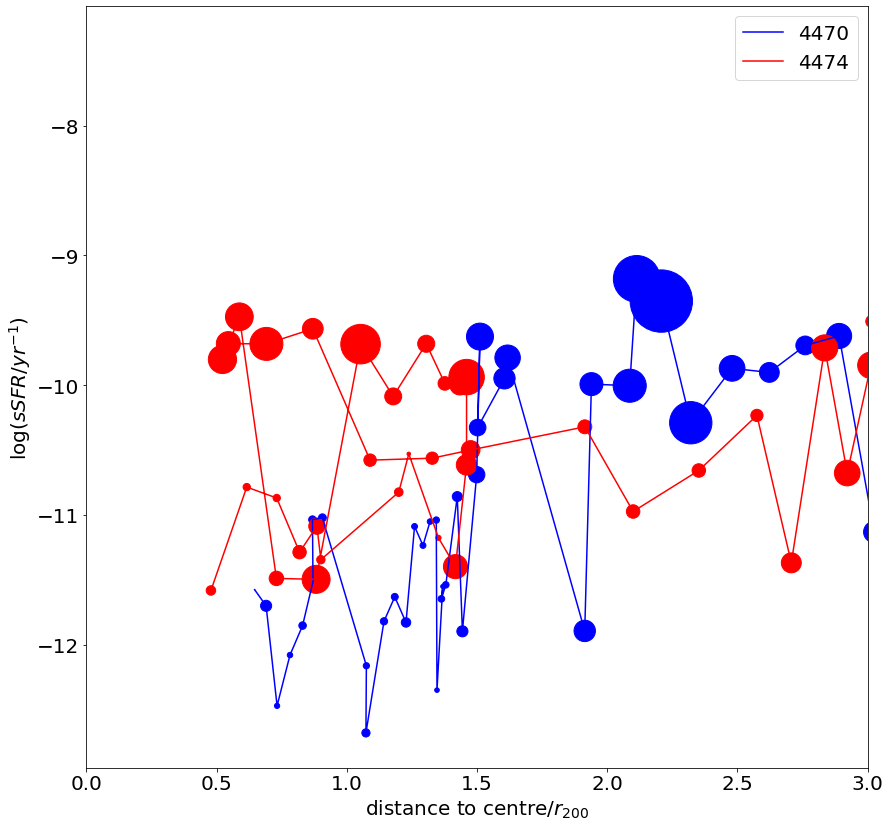

In [20]:
pl.figure(figsize=(14,14))

i1 = np.where(np.isinf(np.log10(SFRor_1))==False)
i2 = np.where(np.isinf(np.log10(SFRor_2))==False)

pl.scatter(dist_1[i1], np.log10(SFRor_1[i1]), s=Mass_1[i1]*1e4, color='blue')
pl.scatter(dist_2[i2], np.log10(SFRor_2[i2]), s=Mass_2[i2]*1e4, color='red')

pl.plot(dist_1[i1], np.log10(SFRor_1[i1]), color='blue', label=S1)
pl.plot(dist_2[i2], np.log10(SFRor_2[i2]), color='red', label=S2)

pl.legend(loc='best')

pl.ylabel('$\log(sSFR/yr^{-1})$')
# pl.ylabel('log(sSFR/yr⁻¹)')
pl.xlabel('distance to centre/$r_{200}$')

pl.xlim(0, 3.)